# **Predict Sale Price**

## Objectives

* Fit and evaluate a regression model to predict the Sale Price of a house in Ames, Iowa

## Inputs

* outputs/datasets/collection/house_prices_records.csv 
* Instructions on which variables to use for data cleaning and feature engineering. They are found in previous notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Features importance plot 

## CRISP-DM

* "Modelling and Evaluation"


---

# Change working directory

To run the notebooks in the editor, we need to change the working directory from its current folder to its parent folder.
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

---

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv"))
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# ML Pipeline with all Data

## ML pipline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer

### Feature Engineering
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

def PiplineDataCleaningFeatureEngineering(model):
  pipeline_base = Pipeline([

    # Data Cleaning

    ("DropFeatures", DropFeatures (features_to_drop = ['EnclosedPorch', 'WoodDeckSF'])),
    
    ("MeanMedianImputer",MeanMedianImputer(imputation_method='median', 
                                            variables=['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'])), 
      
    ("CategoricalImputer",CategoricalImputer(imputation_method='missing',fill_value='Unf',
                                              variables=['GarageFinish', 'BsmtFinType1'])),

     # Feature Engineer
    ("Ordinalencoder", OrdinalEncoder(encoding_method='arbitrary', 
                          variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']) ),

    ("LogTransformer", vt.LogTransformer(
                         variables = ['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage']) ),

    ("PowerTransformer", vt.PowerTransformer(
                         variables=['2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea',
                                    'GrLivArea', 'MasVnrArea', 'TotalBsmtSF']) ),

    ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
                         variables = ['1stFlrSF', 'BsmtUnfSF', 'GarageArea', 'GrLivArea',
                                      'LotArea', 'LotFrontage', 'OpenPorchSF']) ),

    ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                        variables = ['GrLivArea']) ),                                      

    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                        threshold=0.8, selection_method="variance") ),

    ("feat_scaling",StandardScaler() ),

    ("feat_selection",SelectFromModel(model) ),

    ("model",model ),  
  ])

  return pipeline_base


## ML Pipeline for Modelling and Hyperparameter Optimization

Custom Class for Hyperparameter Optimization

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PiplineDataCleaningFeatureEngineering(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


# Grid Search CV - Sklearn

Use standard hyper parameters to find most suitable algorithm

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Quick GridSearch CV - Binary Classifier

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.709639,0.821553,0.873732,0.057943
0,LinearRegression,0.762463,0.795581,0.836674,0.028067
2,RandomForestRegressor,0.694163,0.779925,0.816271,0.045319
5,GradientBoostingRegressor,0.629836,0.771426,0.836809,0.073205
4,AdaBoostRegressor,0.659639,0.736969,0.777502,0.041708
6,XGBRegressor,0.637822,0.69922,0.748881,0.044521
1,DecisionTreeRegressor,0.494971,0.581389,0.667303,0.065299


### Extensive search on most suitable model to find best hyperparameter configuration

The following models and their associated parameters were defined for the extensive search process, based on their initial performance metrics, including mean score, max score, and standard deviation:

In [11]:
# These hyperparameter configurations were obtained from Code Institute Scikit-Learn Unit 6:

models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                           'model__max_depth': [None, 3, 15],
                           'model__min_samples_split': [2, 50],
                           'model__min_samples_leaf': [1,50],
    },

    "LinearRegression":{},

    "RandomForestRegressor":{'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
    },
    
    "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
                                 'model__learning_rate':[0.1, 0.01, 0.001],
                                 'model__max_depth': [3,15, None],
                                 'model__min_samples_split': [2,50],
                                 'model__min_samples_leaf': [1,50],
                                 'model__max_leaf_nodes': [None,50],
    }
}

Extensive GridSearch CV

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Check results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__max_leaf_nodes,model__learning_rate
25,ExtraTreesRegressor,0.715627,0.827274,0.867456,0.056572,15,1,2,50,NaN,NaN
24,ExtraTreesRegressor,0.718258,0.826109,0.872071,0.055418,15,1,2,100,NaN,NaN
26,ExtraTreesRegressor,0.714288,0.824802,0.873355,0.056973,15,1,2,150,NaN,NaN
0,ExtraTreesRegressor,0.709639,0.821553,0.873732,0.057943,None,1,2,100,NaN,NaN
2,ExtraTreesRegressor,0.711446,0.821309,0.874617,0.05733,None,1,2,150,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
266,GradientBoostingRegressor,0.034391,0.057737,0.076918,0.013735,3,1,2,50,50,0.001
260,GradientBoostingRegressor,0.040587,0.056444,0.068839,0.009194,3,50,2,50,None,0.001
263,GradientBoostingRegressor,0.040587,0.056444,0.068839,0.009194,3,50,50,50,None,0.001
275,GradientBoostingRegressor,0.040587,0.056444,0.068839,0.009194,3,50,50,50,50,0.001


### Determine the best model among the four options

### 1. 'ExtraTreesRegressor'

In [14]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Parameters for the model

In [15]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

Define the best clf pipeline

In [16]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['LotFrontage', 'BedroomAbvGr',
                                              '2ndFlrSF', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('Ordinalencoder',
                 OrdinalEncoder(...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea'

## Assess Feature Importance

Calculate and display the feature importances of the model stored in the `best_regressor_pipeline` variable using the `.feature_importances_`
* The code below is adapted from Code Institute Scikit-Learn Unit 6

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'YearBuilt', 'TotalBsmtSF']


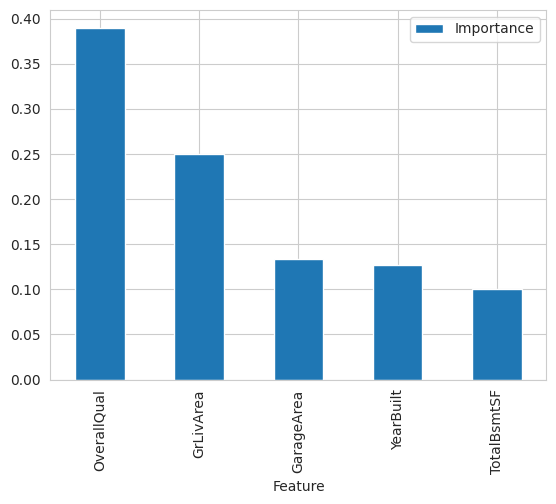

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the feature space may change
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 9 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [20]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train,y_train,pipeline)
    print("* Test Set")
    regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))  
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))  
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluate performance

Model Evaluation 

* Train Set
R2 Score: 0.998
Mean Absolute Error: 1915.612
Mean Squared Error: 9582503.02
Root Mean Squared Error: 3095.562


* Test Set
R2 Score: 0.869
Mean Absolute Error: 19663.336
Mean Squared Error: 906069769.926
Root Mean Squared Error: 30100.993




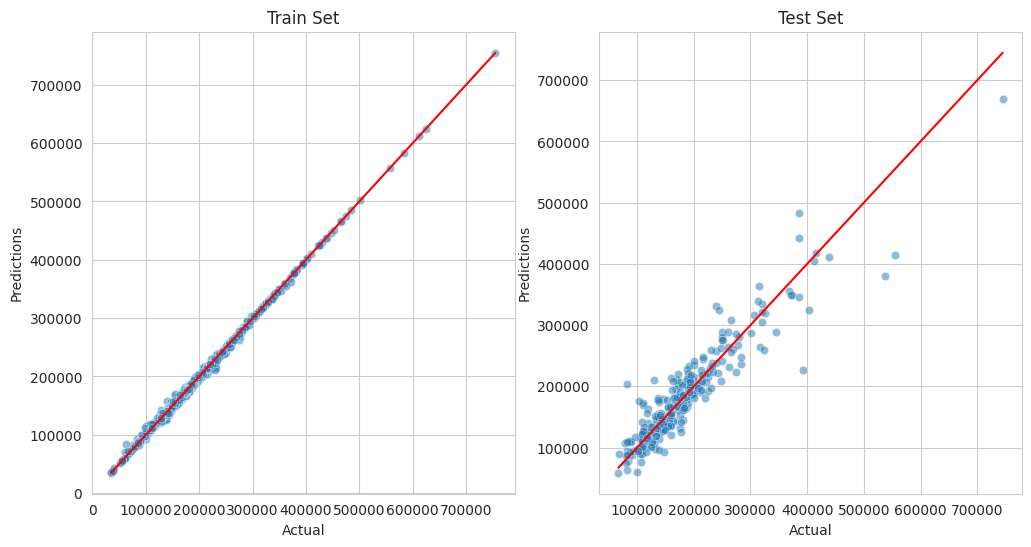

In [21]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### 2.'LinearRegression'

In [22]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(50)

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__max_leaf_nodes,model__learning_rate
25,ExtraTreesRegressor,0.715627,0.827274,0.867456,0.056572,15,1,2,50,NaN,NaN
24,ExtraTreesRegressor,0.718258,0.826109,0.872071,0.055418,15,1,2,100,NaN,NaN
26,ExtraTreesRegressor,0.714288,0.824802,0.873355,0.056973,15,1,2,150,NaN,NaN
0,ExtraTreesRegressor,0.709639,0.821553,0.873732,0.057943,None,1,2,100,NaN,NaN
2,ExtraTreesRegressor,0.711446,0.821309,0.874617,0.05733,None,1,2,150,NaN,NaN
1,ExtraTreesRegressor,0.707081,0.820722,0.876444,0.059397,None,1,2,50,NaN,NaN
3,ExtraTreesRegressor,0.764776,0.81653,0.856586,0.039692,None,1,50,100,NaN,NaN
27,ExtraTreesRegressor,0.7646,0.816386,0.856586,0.039861,15,1,50,100,NaN,NaN
5,ExtraTreesRegressor,0.764114,0.816226,0.855675,0.039717,None,1,50,150,NaN,NaN
29,ExtraTreesRegressor,0.764074,0.816163,0.85576,0.039825,15,1,50,150,NaN,NaN


In [23]:
best_model = grid_search_summary.iloc[20,0]
best_model

'LinearRegression'

Parameters for the model

In [24]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{}

Define the best clf pipeline

In [25]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['LotFrontage', 'BedroomAbvGr',
                                              '2ndFlrSF', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('Ordinalencoder',
                 OrdinalEncoder(...
                                                     'BsmtFinSF1',
                                                     'BsmtFinType1',
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
        

## Assess Feature Importance

Since the 'LinearRegression' object does not have the attribute `feature_importances_`, we can only display the best features without considering their importances.

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the feature space may change
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 9 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

## Evaluate on Train and Test Sets

In [27]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train,y_train,pipeline)
    print("* Test Set")
    regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))  
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))  
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.799
Mean Absolute Error: 23730.18
Mean Squared Error: 1236872367.134
Root Mean Squared Error: 35169.196


* Test Set
R2 Score: 0.712
Mean Absolute Error: 26936.49
Mean Squared Error: 1990529855.726
Root Mean Squared Error: 44615.354




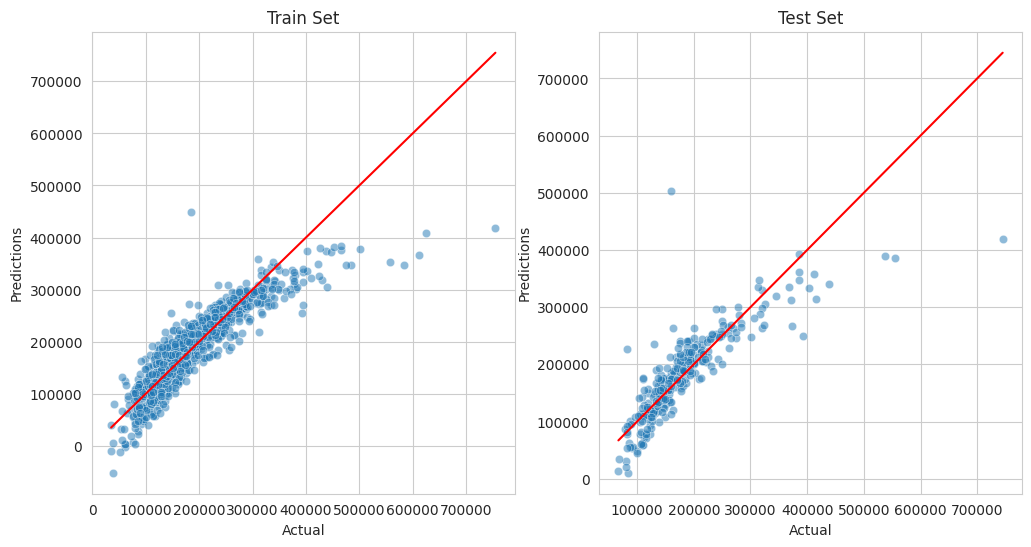

In [28]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

3.'RandomForestRegressor'

In [29]:
best_model = grid_search_summary.iloc[41,0]
best_model

'RandomForestRegressor'

Parameters for the model

In [30]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 15,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

Define the best clf pipeline

In [31]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['LotFrontage', 'BedroomAbvGr',
                                              '2ndFlrSF', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('Ordinalencoder',
                 OrdinalEncoder(...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea'

## Assess Feature Importance

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


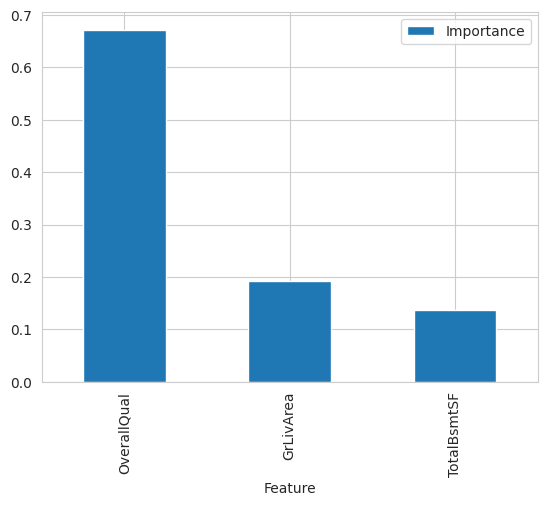

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the feature space may change
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 9 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train,y_train,pipeline)
    print("* Test Set")
    regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))  
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))  
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.9
Mean Absolute Error: 18570.853
Mean Squared Error: 616395190.753
Root Mean Squared Error: 24827.307


* Test Set
R2 Score: 0.816
Mean Absolute Error: 22239.097
Mean Squared Error: 1273712595.385
Root Mean Squared Error: 35689.11




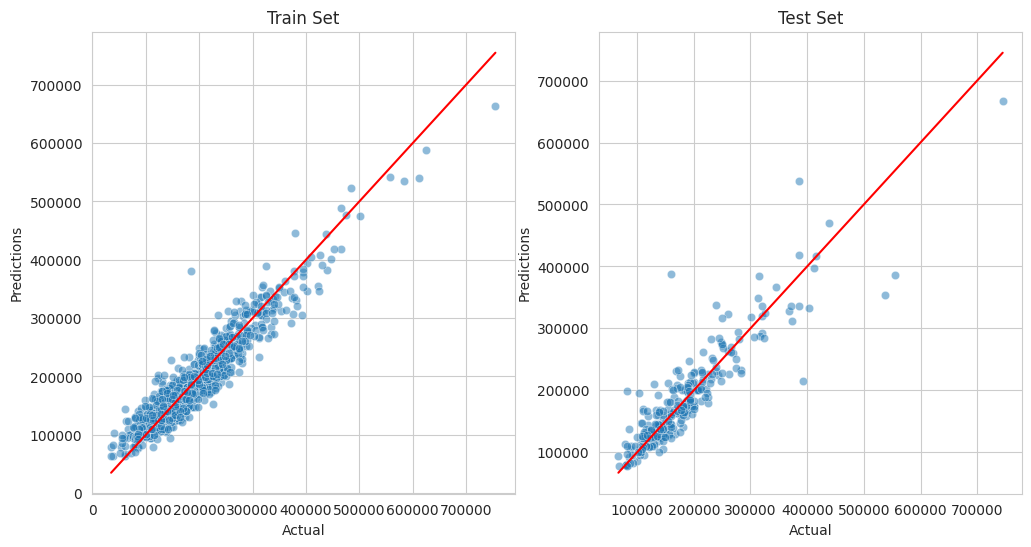

In [34]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### 4.'GradientBoostingRegressor'

In [35]:
best_model = grid_search_summary.iloc[12,0]
best_model

'GradientBoostingRegressor'

In [36]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

In [37]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['LotFrontage', 'BedroomAbvGr',
                                              '2ndFlrSF', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('Ordinalencoder',
                 OrdinalEncoder(...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea'

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


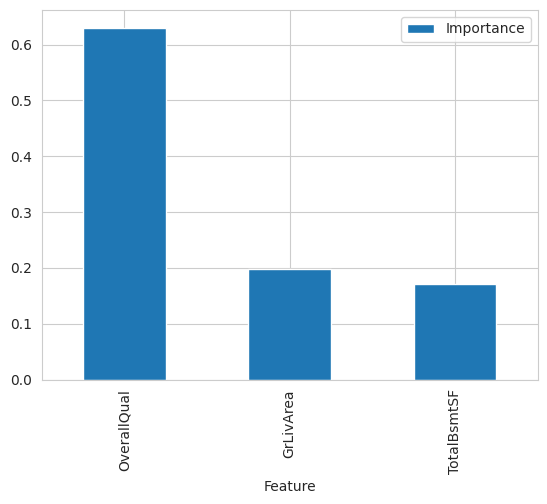

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the feature space may change
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 9 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

In [39]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train,y_train,pipeline)
    print("* Test Set")
    regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))  
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))  
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.834
Mean Absolute Error: 21359.496
Mean Squared Error: 1024460750.793
Root Mean Squared Error: 32007.198


* Test Set
R2 Score: 0.761
Mean Absolute Error: 24335.071
Mean Squared Error: 1648866814.119
Root Mean Squared Error: 40606.241




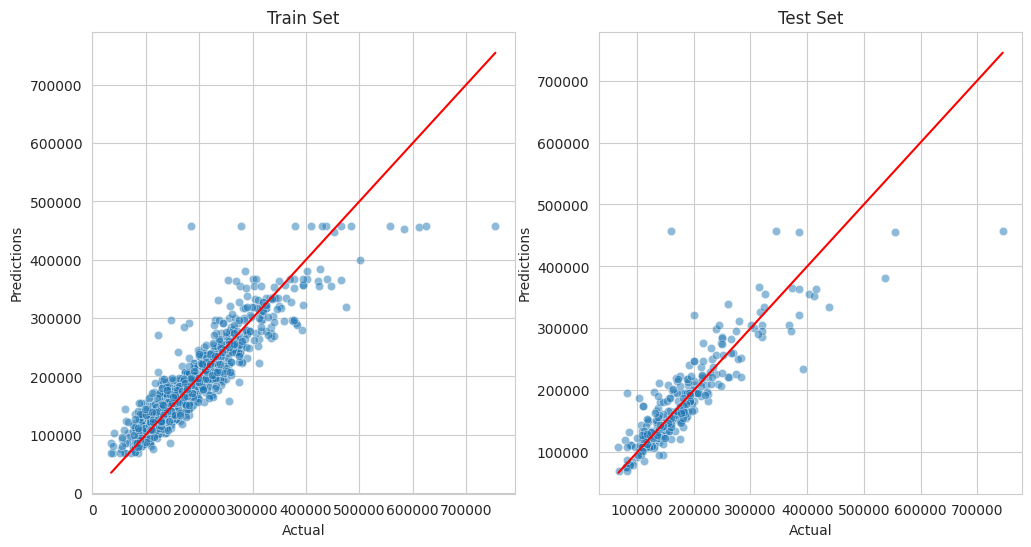

In [40]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

## Comparison of Regression Pipelines

To determine the best pipeline, we should consider the performance metrics on both the train and test sets:

### `ExtraTreesRegressor`:

* This pipeline shows exceptional performance on the training set, achieving an R2 score of 0.998 and low errors across the metrics. On the test set, it performs well with an R2 score of 0.869 and a relatively low mean absolute error.
The root mean squared error is higher compared to other pipelines, indicating a slightly larger spread of errors.
However, it's important to note that the ExtraTreesRegressor model seems to be overfitting, as indicated by the significantly higher test set errors compared to the train set errors.

### `RandomForestRegressor`:

* This pipeline also performs well on both the training and test sets. It achieves a high R2 score of 0.9 on the training set and 0.816 on the test set. The mean absolute error and root mean squared error are relatively lower compared to the other pipelines, indicating better accuracy and precision.

### `GradientBoostingRegressor`:

* This pipeline has a lower R2 score and higher errors compared to the previous two pipelines. While it still performs reasonably well, it falls behind the previous two pipelines in terms of accuracy.

### `LinearRegression`:

* This pipeline has the lowest performance among other pipliness. It has the lowest R2 score, failing to meet the performance goal of 0.75 on the test set. Additionally, it demonstrates the highest errors on both the training and test sets.

Based on these observations, the `RandomForestRegressor` pipeline seems to be the most suitable choice. It exhibits a good balance of accuracy and precision on both the training and test sets, with relatively lower errors and higher R2 scores compared to the other pipelines.

# Refit pipeline with best features

In [41]:
best_features

['GrLivArea', 'OverallQual', 'TotalBsmtSF']

In [42]:
# Pipeline Optmization: Model
def PiplineDataCleaningFeatureEngineering(model):
  pipeline_base = Pipeline([

 # Feature Engineer

    ("LogTransformer", vt.LogTransformer(
                         variables = ['GrLivArea']) ),

    ("PowerTransformer", vt.PowerTransformer(
                         variables=['GrLivArea', 'TotalBsmtSF']) ),

    ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
                         variables = ['GrLivArea']) ),

    ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                        variables = ['GrLivArea']) ),                                      

    # we don't need SmartCorrelatedSelection

    ("feat_scaling",StandardScaler() ),

    # ("feat_selection",SelectFromModel(model) )

    ("model",model ),  
  ])

  return pipeline_base

## Split Train Test Set, considering only with best features

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


In [44]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(1168, 3) (1168,) (292, 3) (292,)


,GrLivArea,OverallQual,TotalBsmtSF
618,1828,9,1822
870,894,5,894
92,964,5,876


## Grid Search CV - SKLearn

Using the most suitable model and its best hyperparameter configuration.

In [45]:
models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}
models_search

{'RandomForestRegressor': RandomForestRegressor(random_state=0)}

In [46]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

In [47]:
params_search = {
    "RandomForestRegressor": {
        'model__max_depth': [15],
        'model__max_leaf_nodes': [50],
        'model__min_samples_leaf': [1],
        'model__min_samples_split': [2],
        'model__n_estimators': [100],
    }
}
params_search

{'RandomForestRegressor': {'model__max_depth': [15],
  'model__max_leaf_nodes': [50],
  'model__min_samples_leaf': [1],
  'model__min_samples_split': [2],
  'model__n_estimators': [100]}}

### GridSearch CV

In [48]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


### Check results

In [49]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestRegressor,0.709336,0.797436,0.834658,0.045787,15,50,1,2,100


### Define the best model

In [50]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

### Define the best regression pipeline

In [51]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('LogTransformer', LogTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['GrLivArea', 'TotalBsmtSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GrLivArea'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=15, max_leaf_nodes=50,
                                       random_state=0))])

## Assess Feature Importance

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


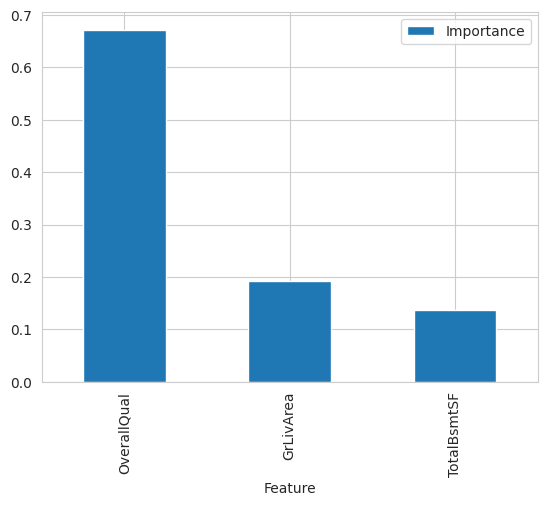

In [52]:
# The code below is adapted from Code Institute Scikit-Learn Unit 6

data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.9
Mean Absolute Error: 18570.853
Mean Squared Error: 616395190.753
Root Mean Squared Error: 24827.307


* Test Set
R2 Score: 0.816
Mean Absolute Error: 22239.097
Mean Squared Error: 1273712595.385
Root Mean Squared Error: 35689.11




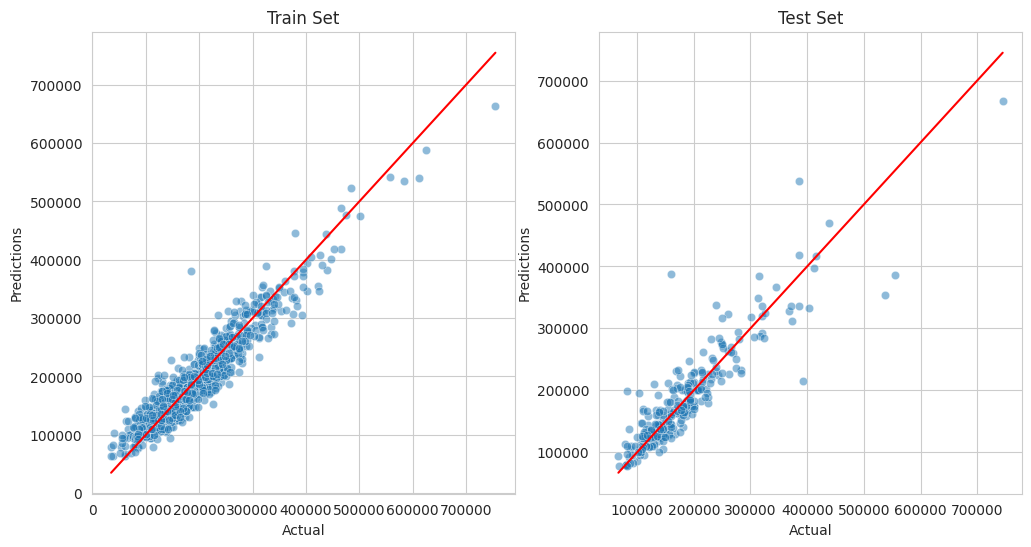

In [53]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

The `RandomForestRegressor` pipeline, trained on the best features, demonstrates consistent performance. It achieves an high R2 score of 0.9 on the training set and 0.816 on the test set, with low errors. 

These indicate the pipeline is effective in predicting the sale price accurately.

---

# Push files to Repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* Features importance plot

In [52]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set

In [53]:
X_train.head()

,GrLivArea,OverallQual,TotalBsmtSF
618,1828,9,1822
870,894,5,894
92,964,5,876
817,1689,8,1568
302,1541,7,1541


In [54]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [55]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [56]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

In [57]:
X_test.head()

,GrLivArea,OverallQual,TotalBsmtSF
529,2515,6,2035
491,1578,6,806
459,1203,5,709
279,2022,7,1160
655,1092,6,525


In [58]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [59]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [60]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling Pipeline

In [61]:
best_regressor_pipeline

Pipeline(steps=[('LogTransformer', LogTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['GrLivArea', 'TotalBsmtSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GrLivArea'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=15, max_leaf_nodes=50,
                                       random_state=0))])

In [62]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v1/best_regressor_pipeline.pkl']

## Feature importance plot

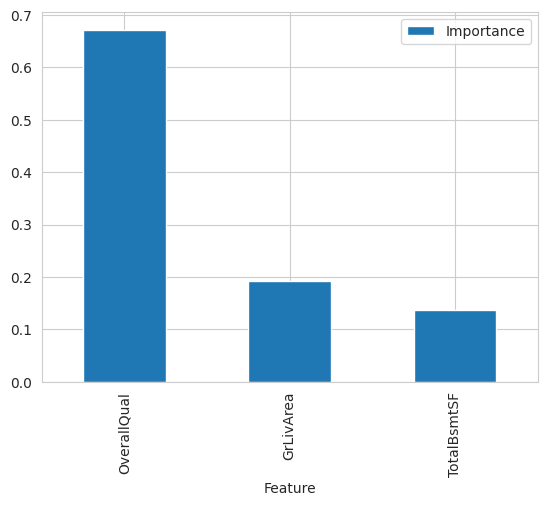

In [63]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

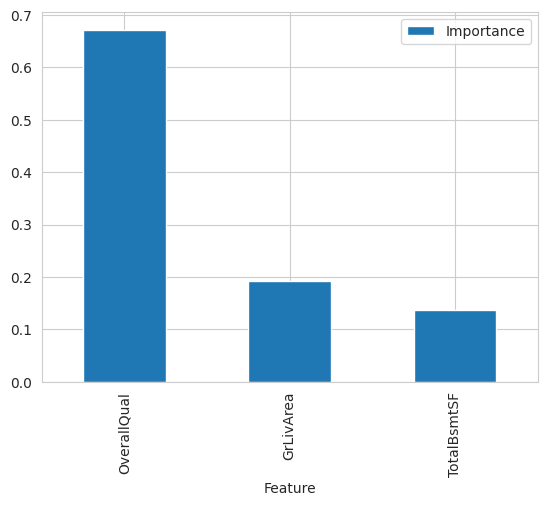

In [64]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')